<a href="https://colab.research.google.com/github/Yinghui-HE/Dogs-vs-Cats/blob/main/Dogs%20vs%20Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Machine Learning Final Project DUE: Friday May 7th 11:59pm**

**Note: Please read all the instructions carefully before starting the project.**

For your final project you will build an ML model to analyze a dataset of your choice. You are welcome to keep working on the data in your EDA project if your data is large enough (at least 1000 rows for simple models and at least 10,000 for more complex models) or you can choose from the datasets/project suggestions below.

In this project make sure that you:
- Have a large enough dataset
- Split your data in training and testing
- Explore your data to inform which type of model to choose (no need if you are using your EDA dataset)
- Try different models on your training dataset - then select the most promising model
- Use cross validation to fine tune the model’s parameters such as alpha in lasso
- Simplify your model using regularization, prunnning, drop-out, etc. to avoid overfitting
- Communicate your model’s performance and make sure you compare it to a benchmark when appropriate
- Plot interesting graphs and results
- Write and publish your article to medium
- Commit your code to your GitHub

Please ensure you handle all the preprocessing before the modeling.

Suggestions for project:
You can take a look at the resources given below for choosing a dataset for your project. 

- Traffic sign detection - https://benchmark.ini.rub.de/gtsdb_dataset.html
- Cat and dog classifier - https://www.kaggle.com/c/dogs-vs-cats/data
- Other datasets from Kaggle - https://www.kaggle.com/data/41592

## **Grading Criteria**

- Show clear exploration of the data to justify model choice
- Train mutliple models and clearly articulate why you chose your final model
- Show your performance on test dataset
- Clear and concise write-up with clear well-documented figures
- Commit your code to GitHub

## **Submission Details**

This is an individual assignment. You may not work in groups. The assignment is due on Friday (05/07/2021)
- To submit your assignment, download your notebook and the dataset, zip the dataset and notebook, and submit the zipped file on blackboard.
- Make sure the notebook is named in the format - Final_LastName_FirstName. If you are submitting a zipped file, please name the file as well in the same format.
- Please include the link to access your blog and your github repo in your notebook.
- Also include the link to your notebook, github repo and the blog in the submission on blackboard. Please ensure the TAs have the required access to your notebooks and the github repo.

**Note - If the dataset is too large to be zipped and submitted on blackboard, only submit your notebook, add your dataset to your google drive and share a link to the file in your notebook.**

EDA Example with blog post on medium - https://heyinghu.medium.com/dogs-vs-cats-a-project-in-exploration-data-analysis-and-machine-learning-b54e38c5b4c7

Dataset can be found in the github repo - https://github.com/Yinghui-HE/Dogs-vs-Cats

Copy of the dataset is also available at - https://drive.google.com/drive/folders/1CTCKIWujqG6VfJtmU144gOQm3-OyUUds?usp=sharing


In [22]:
# import all required libraries
import zipfile
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import shutil
import os
from PIL import Image
import random
from torch import nn

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator

# Data Collection (Cat and dog classifier):

*   Importing data from kaggle dataset from https://www.kaggle.com/c/dogs-vs-cats/data




In [3]:
def make_directory(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)
cwd = os.getcwd()
print("current directory: ", cwd)

current directory:  /content


*   Split the data in training and testing


In [5]:
# import dataset
DATASET_PATH = "./output"
make_directory(DATASET_PATH)

# extract train data
with zipfile.ZipFile('./input/train.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

# extract test data
with zipfile.ZipFile('./input/test1.zip', 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

# Split the data in training and testing
TRAIN_DATA_PATH = os.path.sep.join([DATASET_PATH, 'train/'])
TEST_DATA_PATH = os.path.sep.join([DATASET_PATH, 'test1/'])
train_filenames = os.listdir(TRAIN_DATA_PATH)
test_filenames = os.listdir(TEST_DATA_PATH)

print(len(train_filenames), len(test_filenames))

25000 12500


# Exploration Data Analysis

*   Plot a few dog photos from dogs vs cat dataset


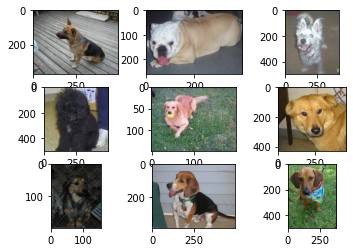

In [6]:
# show image from training data
# random_train = random.choice(train_filenames)
# Image.open(os.path.sep.join([TRAIN_DATA_PATH, random_train])) 

# image from testing data
# random_test = random.choice(test_filenames)
# Image.open(os.path.sep.join([TEST_DATA_PATH, random_test])) 
start_img_index = random.randint(0, 1000)

# plot first few dog images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = TRAIN_DATA_PATH + 'dog.' + str(i+start_img_index) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

*   Plot a few cat photos from dogs vs cat dataset


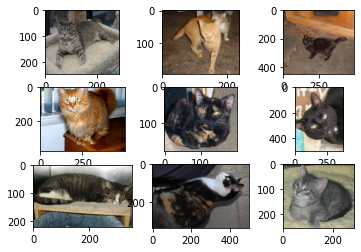

In [7]:
# plot cat photos from the dogs vs cats dataset
start_img_index = random.randint(0, 1000)

# plot first few cat images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# define filename
	filename = TRAIN_DATA_PATH + 'cat.' + str(i+start_img_index) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()


*   Load the images progressively to "dataset_dogs_vs_cats" folder and 
*   Split the data into training (75%) and testing subsets (25%)

In [8]:
# Uses the Keras image processing API to load all 25,000 photos in the training 
# dataset and reshapes them to 200×200 square photos
# load the images progressively using the Keras ImageDataGenerator class and flow_from_directory() API.

# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)

# we can enumerate all image files in the dataset and copy them into the dogs/ or cats/ subdirectory based on their filename.

# seed random number generator
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25 # hold back 25% of the images into the test dataset
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in os.listdir(TRAIN_DATA_PATH):
	src = TRAIN_DATA_PATH + '/' + file
	dst_dir = 'train/'
	if random.random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		shutil.copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		shutil.copyfile(src, dst)
  
print("after this section, data are splitted into 'train' and 'test' \nsubdirectories under the directory 'dataset_dogs_vs_cats'")

after this section, data are splitted into 'train' and 'test' 
subdirectories under the directory 'dataset_dogs_vs_cats'


In [36]:
# Code to clear data in folder
# shutil.rmtree('dataset_dogs_vs_cats')

*   Explore the data to inform which type of model to choose

In [ ]:
# print("train_filenames:", train_filenames)
# print("test_filenames:", test_filenames)

# add corresponding categories for training data
animal_categories = []
animal_codes = []
for train_filename in train_filenames:
  animal_category = train_filename.split(".")[0]
  animal_categories.append(animal_category)
  if animal_category == 'dog':
    animal_codes.append(1)
  else:
    animal_codes.append(0)

df = pd.DataFrame({'filename': train_filenames, 
                   'animal_category' : animal_categories,
                   'animal_code' : animal_codes})

print("\ndataframe:")
df.head(10)

In [10]:
print(df.shape)

(25000, 3)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         25000 non-null  object
 1   animal_category  25000 non-null  object
 2   animal_code      25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


dog    12500
cat    12500
Name: animal_category, dtype: int64


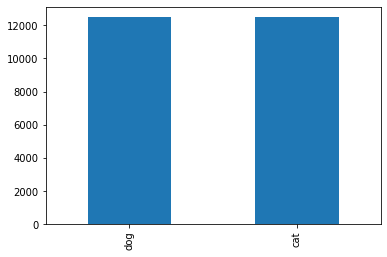

In [12]:
print(df["animal_category"].value_counts())
df["animal_category"].value_counts().plot(kind = "bar")

# Modeling

*   Try different models on the training dataset - then select the most promising model
    *   Define different models in different Python functions
* Function to visualize the training results

In [13]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Model 1: Neural Network Model with One Convolution Layer

*   Defining a convolutional neural network model with one convolution layer

In [56]:
# define cnn model
def define_cnn_model_one_vgg():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  print()
  return model

In [59]:
# define model
model = define_cnn_model_one_vgg()

# define an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1
# create data generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
  class_mode='binary', batch_size=200, target_size=(150, 150))
test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
  class_mode='binary', batch_size=50, target_size=(150, 150))

print("\nlength of train_iterator:", len(train_it))
print("length of test_iterator:", len(test_it))
print()

# fit model
# history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
  # validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=15, 
                    validation_data=test_it, validation_steps=len(test_it))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               22429824  
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 22,430,849
Trainable params: 22,430,849
Non-trainable params: 0
_________________________________________________________________

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.

length of train_iter

  *   Evaluating the model and visualizing the training result


127/127 [==============================] - 63s 494ms/step - loss: 0.6886 - accuracy: 0.5369
test loss: %, test accuracy:% 0.688648521900177 0.5368871688842773


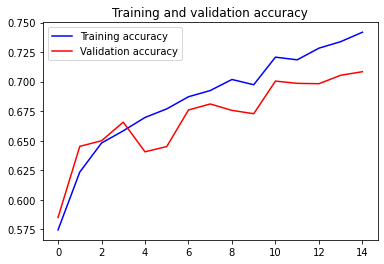

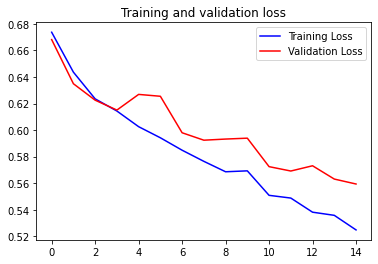

In [61]:
# evaluate model
test_loss, test_acc = model.evaluate(test_it, steps=len(test_it))
print("test loss: %, test accuracy:%", test_loss, test_acc)

# visualizing the training result
plot_result(history)

## Model 2: Neural Network Model with Two Convolution Layers

In [62]:
# define cnn model
def define_cnn_model_two_vgg():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  print()
  return model

In [63]:
# define model
model = define_cnn_model_two_vgg()

# define an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1
# create data generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
  class_mode='binary', batch_size=200, target_size=(150, 150))
test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
  class_mode='binary', batch_size=50, target_size=(150, 150))

# fit model
# history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
  # validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=15, 
                    validation_data=test_it, validation_steps=len(test_it))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 82944)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               10616960  
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

  *   Evaluating the model and visualizing the training result


127/127 [==============================] - 63s 497ms/step - loss: 0.5528 - accuracy: 0.7189
test loss: 0.5527574419975281, test accuracy: 0.7188640236854553


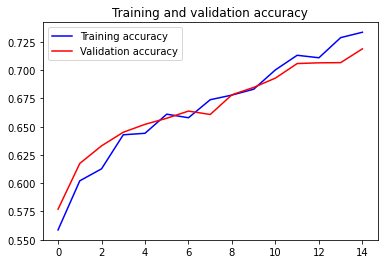

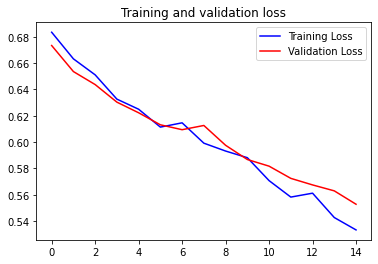

In [66]:
# evaluate model
test_loss, test_acc = model.evaluate(test_it, steps=len(test_it))
print("test loss: " + str(test_loss) + ", test accuracy: " + str(test_acc))

# visualizing the training result
plot_result(history)

## Model 3: Neural Network Model with Three Convolution Layers

In [14]:
# define cnn model
def define_cnn_model_three_vgg():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  print()
  return model

In [15]:
# define model
model = define_cnn_model_three_vgg()

# define an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1
# create data generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
  class_mode='binary', batch_size=200, target_size=(150, 150))
test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
  class_mode='binary', batch_size=50, target_size=(150, 150))

# fit model
# history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
  # validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=15, 
                    validation_data=test_it, validation_steps=len(test_it))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

*   Evaluating the model and visualizing the training result



127/127 [==============================] - 72s 566ms/step - loss: 0.5655 - accuracy: 0.7076
test loss: 0.5654906630516052, test accuracy: 0.7075995802879333


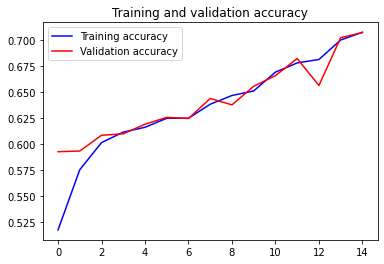

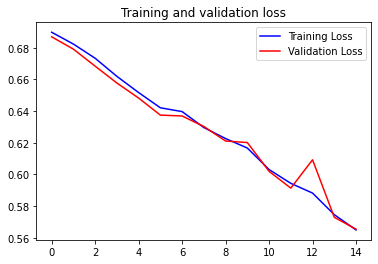

In [16]:
# evaluate model
test_loss, test_acc = model.evaluate(test_it, steps=len(test_it))
print("test loss: " + str(test_loss) + ", test accuracy: " + str(test_acc))

# visualizing the training result
plot_result(history)

# Simplifying the Model (Dropout Regularization)



In [25]:
# define cnn model with dropout
# a dropout of 20% is applied after each convolution layer, 
#   with a larger dropout rate of 50% applied after fully connected layer in the classifer part of the model
def define_cnn_model_dropout():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  # model.add(Conv2D(64, (3, 3), activation='relu'))
  # model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(0.2))
  # model.add(Conv2D(128, (3, 3), activation='relu'))
  # model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  print()
  return model

In [26]:
# define model
model_dropout = define_cnn_model_dropout()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               22429824  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [23]:
# define an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1
# create data generator
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
  class_mode='binary', batch_size=200, target_size=(150, 150))
test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
  class_mode='binary', batch_size=50, target_size=(150, 150))

# fit model
history_dropout = model_dropout.fit(train_it, steps_per_epoch=len(train_it), epochs=15, 
                    validation_data=test_it, validation_steps=len(test_it))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/15
94/94 [==============================] - 346s 4s/step - loss: 0.6974 - accuracy: 0.5246 - val_loss: 0.6824 - val_accuracy: 0.5869
Epoch 2/15
94/94 [==============================] - 340s 4s/step - loss: 0.6785 - accuracy: 0.5757 - val_loss: 0.6681 - val_accuracy: 0.6035
Epoch 3/15
94/94 [==============================] - 335s 4s/step - loss: 0.6707 - accuracy: 0.5890 - val_loss: 0.6569 - val_accuracy: 0.6180
Epoch 4/15
94/94 [==============================] - 336s 4s/step - loss: 0.6613 - accuracy: 0.6062 - val_loss: 0.6500 - val_accuracy: 0.6213
Epoch 5/15
94/94 [==============================] - 335s 4s/step - loss: 0.6497 - accuracy: 0.6203 - val_loss: 0.6492 - val_accuracy: 0.6254
Epoch 6/15
94/94 [==============================] - 336s 4s/step - loss: 0.6457 - accuracy: 0.6268 - val_loss: 0.6379 - val_accuracy: 0.6335
Epoch 7/15
94/94 [==============================] - 336s 4s/step - lo

127/127 [==============================] - 39s 307ms/step - loss: 0.7107 - accuracy: 0.5146
test loss: 0.713750958442688, test accuracy: 0.5067428350448608


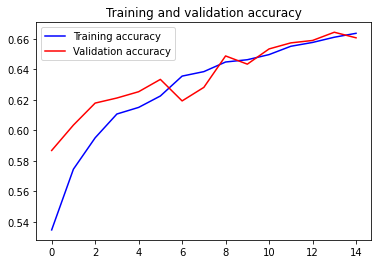

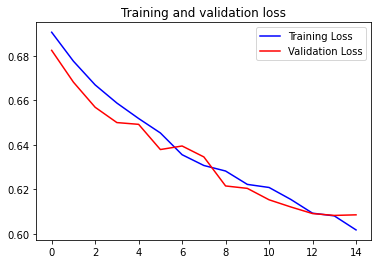

In [27]:
# evaluate model
test_loss, test_acc = model_dropout.evaluate(test_it, steps=len(test_it))
print("test loss: " + str(test_loss) + ", test accuracy: " + str(test_acc))

# visualizing the training result
plot_result(history_dropout)

# Summary
For the three models with different amounts of convolution layers (the combination of Conv2D and MaxPool2D layers), the accuracies of the models are as follows:
* Model 1 has an accuracy of 0.5369 (one convolution layer).
* Model 2 with an accuracy of 0.7189 (two convolution layers).
* Model 3 has an accuracy of 0.7076 (three convolution layers). 
* Model 1 with dropout regularization has an accuracy of 0.5164 (one convolution layer).

From the results above, we can tell that there's an increase in accuracies between one and two convolution layer(s) but not in accuracies between two and three convolution layers. Thus, there's no overall pattern between the number of layers and the accuracy of the model.


Besides, by adding dropout regularization to Model 1, the accuracy is not increased much. However, the obvious overfitting behavior after epoch 3 for Model 1 has been reduced or delayed to a great extent. For further exploration and optimization, a larger dropout rate after the convolution layer could be considered.